In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [81]:
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os

def plot_training_metrics(json_file_1gpu, json_file_2gpus, path_to_save_plots, model_name):
    """
    Generates plots comparing training metrics from 1-GPU and 2-GPU setups.

    Args:
        json_file_1gpu (str): Path to the JSON file containing 1-GPU training data.
        json_file_2gpus (str): Path to the JSON file containing 2-GPU training data.
        path_to_save_plots (str): Path to save the generated plots.
        model_name (str): Name of the model, to be included in plot titles.
    """

    def extract_data(json_file):
        """Extracts data from JSON file and returns the values."""
        with open(json_file, 'r') as f:
            data = json.load(f)

        # Assuming one entry in json object for 1 gpu case and two entry for 2 gpu case.
        if len(data) == 1:
            key = list(data.keys())[0]
            return data[key]
        elif len(data) == 2:
             keys = list(data.keys())
             return data[keys[0]], data[keys[1]]

        else:
            keys = list(data.keys())
            return data[keys[1]], data[keys[2]]

    # Load JSON data
    data_1gpu = extract_data(json_file_1gpu)
    data_2gpus_rank0, data_2gpus_rank1 = extract_data(json_file_2gpus)


    # Extract data for 1 GPU
    train_times_1gpu = data_1gpu.get('training_times', [])
    train_losses_1gpu = data_1gpu.get('train_losses', [])
    train_acc_1gpu = data_1gpu.get('train_accurcy', [])
    val_times_1gpu = data_1gpu.get('validation_times', [])
    val_losses_1gpu = data_1gpu.get('validation_losses', [])
    val_acc_1gpu = data_1gpu.get('validation_accurcy', [])
    test_acc_1gpu = data_1gpu.get('test_acc', 0)


    # Extract data for 2 GPUs (rank 0)
    train_times_2gpus_rank0 = data_2gpus_rank0.get('training_times', [])
    train_losses_2gpus_rank0 = data_2gpus_rank0.get('train_losses', [])
    train_acc_2gpus_rank0 = data_2gpus_rank0.get('train_accurcy', [])
    val_times_2gpus_rank0 = data_2gpus_rank0.get('validation_times', [])
    val_losses_2gpus_rank0 = data_2gpus_rank0.get('validation_losses', [])
    val_acc_2gpus_rank0 = data_2gpus_rank0.get('validation_accurcy', [])
    test_acc_2gpus_rank0 = data_2gpus_rank0.get('test_acc', 0)


    # Extract data for 2 GPUs (rank 1)
    train_times_2gpus_rank1 = data_2gpus_rank1.get('training_times', [])
    train_losses_2gpus_rank1 = data_2gpus_rank1.get('train_losses', [])
    train_acc_2gpus_rank1 = data_2gpus_rank1.get('train_accurcy', [])
    val_times_2gpus_rank1 = data_2gpus_rank1.get('validation_times', [])
    val_losses_2gpus_rank1 = data_2gpus_rank1.get('validation_losses', [])
    val_acc_2gpus_rank1 = data_2gpus_rank1.get('validation_accurcy', [])
    test_acc_2gpus_rank1 = data_2gpus_rank1.get('test_acc', 0)

    # Calculate averages for 2 GPUs
    train_times_2gpus_avg = np.mean([train_times_2gpus_rank0, train_times_2gpus_rank1], axis=0) if (train_times_2gpus_rank0 and train_times_2gpus_rank1) else []
    train_losses_2gpus_avg = np.mean([train_losses_2gpus_rank0, train_losses_2gpus_rank1], axis=0) if (train_losses_2gpus_rank0 and train_losses_2gpus_rank1) else []
    train_acc_2gpus_avg = np.mean([train_acc_2gpus_rank0, train_acc_2gpus_rank1], axis=0) if (train_acc_2gpus_rank0 and train_acc_2gpus_rank1) else []
    val_times_2gpus_avg = np.mean([val_times_2gpus_rank0, val_times_2gpus_rank1], axis=0) if (val_times_2gpus_rank0 and val_times_2gpus_rank1) else []
    val_losses_2gpus_avg = np.mean([val_losses_2gpus_rank0, val_losses_2gpus_rank1], axis=0) if (val_losses_2gpus_rank0 and val_losses_2gpus_rank1) else []
    val_acc_2gpus_avg = np.mean([val_acc_2gpus_rank0, val_acc_2gpus_rank1], axis=0) if (val_acc_2gpus_rank0 and val_acc_2gpus_rank1) else []
    test_acc_2gpus_avg = np.mean([test_acc_2gpus_rank0, test_acc_2gpus_rank1]) if (test_acc_2gpus_rank0 and test_acc_2gpus_rank1) else 0

    epochs = range(1, len(train_losses_1gpu) + 1) if train_losses_1gpu else []

    # --- Plotting ----
    plt.figure(figsize=(15, 15))

    # Plot Training Loss
    plt.subplot(3, 2, 1)
    if train_losses_1gpu:
         plt.plot(epochs, train_losses_1gpu, label='1 GPU Training Loss')
    if len(train_losses_2gpus_rank0) > 0:
        plt.plot(epochs, train_losses_2gpus_rank0, label='2 GPUs (Rank 0) Training Loss')
    if len(train_losses_2gpus_rank1) > 0:
        plt.plot(epochs, train_losses_2gpus_rank1, label='2 GPUs (Rank 1) Training Loss')
    if len(train_losses_2gpus_avg) > 0:
        plt.plot(epochs, train_losses_2gpus_avg, label='2 GPUs (Avg) Training Loss')

    plt.title(f'{model_name} - Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Plot Validation Loss
    plt.subplot(3, 2, 2)
    if val_losses_1gpu:
        plt.plot(epochs, val_losses_1gpu, label='1 GPU Validation Loss')
    if len(val_losses_2gpus_rank0) > 0:
        plt.plot(epochs, val_losses_2gpus_rank0, label='2 GPUs (Rank 0) Validation Loss')
    if len(val_losses_2gpus_rank1) > 0:
         plt.plot(epochs, val_losses_2gpus_rank1, label='2 GPUs (Rank 1) Validation Loss')
    if len(val_losses_2gpus_avg) > 0:
        plt.plot(epochs, val_losses_2gpus_avg, label='2 GPUs (Avg) Validation Loss')
    plt.title(f'{model_name} - Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Plot Training Accuracy
    plt.subplot(3, 2, 3)
    if train_acc_1gpu:
        plt.plot(epochs, train_acc_1gpu, label='1 GPU Training Accuracy')
    if len(train_acc_2gpus_rank0) > 0:
        plt.plot(epochs, train_acc_2gpus_rank0, label='2 GPUs (Rank 0) Training Accuracy')
    if len(train_acc_2gpus_rank1) > 0:
        plt.plot(epochs, train_acc_2gpus_rank1, label='2 GPUs (Rank 1) Training Accuracy')
    if len(train_acc_2gpus_avg) > 0:
        plt.plot(epochs, train_acc_2gpus_avg, label='2 GPUs (Avg) Training Accuracy')
    plt.title(f'{model_name} - Training Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot Validation Accuracy
    plt.subplot(3, 2, 4)
    if val_acc_1gpu:
        plt.plot(epochs, val_acc_1gpu, label='1 GPU Validation Accuracy')
    if len(val_acc_2gpus_rank0) > 0:
         plt.plot(epochs, val_acc_2gpus_rank0, label='2 GPUs (Rank 0) Validation Accuracy')
    if len(val_acc_2gpus_rank1) > 0:
         plt.plot(epochs, val_acc_2gpus_rank1, label='2 GPUs (Rank 1) Validation Accuracy')
    if len(val_acc_2gpus_avg) > 0:
         plt.plot(epochs, val_acc_2gpus_avg, label='2 GPUs (Avg) Validation Accuracy')
    plt.title(f'{model_name} - Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot Training Times
    plt.subplot(3, 2, 5)
    if train_times_1gpu:
        plt.plot(epochs, train_times_1gpu, label='1 GPU Training Time')
    if len(train_times_2gpus_avg) > 0:
        plt.plot(epochs, train_times_2gpus_avg, label='2 GPUs (Avg) Training Time')
    if len(train_times_2gpus_rank0) > 0:
        plt.plot(epochs, train_times_2gpus_rank0, label='2 GPUs (Rank 0)')
    if len(train_times_2gpus_rank1) > 0:
        plt.plot(epochs, train_times_2gpus_rank1, label='2 GPUs (Rank 1)')
    plt.title(f'{model_name} - Training Time per Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Time (s)')
    plt.legend()

    # --- Bar chart for total validation time ---
    val_time_1gpu_total = np.sum(val_times_1gpu) if val_times_1gpu else 0
    val_time_2gpus_total_rank0 = np.sum(val_times_2gpus_rank0) if val_times_2gpus_rank0 else 0
    val_time_2gpus_total_rank1 = np.sum(val_times_2gpus_rank1) if val_times_2gpus_rank1 else 0
    val_time_2gpus_total_avg = np.sum(val_times_2gpus_avg) if len(val_times_2gpus_avg) > 0 else 0

    labels = ['1 GPU', '2 GPUs (Rank 0)', '2 GPUs (Rank 1)', '2 GPUs (Avg)']
    total_val_times = [val_time_1gpu_total, val_time_2gpus_total_rank0,val_time_2gpus_total_rank1, val_time_2gpus_total_avg]

    plt.subplot(3,2,6)
    bar_width = 0.6
    index = np.arange(len(labels))
    plt.bar(index, total_val_times, color=['skyblue', 'lightcoral', 'coral', 'lightgreen'], width = bar_width)
    plt.xticks(index, labels)
    plt.title(f'{model_name} - Total Validation Time')
    plt.ylabel('Time (s)')
    plt.tight_layout()


    # Create the directory if it doesn't exist
    os.makedirs(path_to_save_plots, exist_ok=True)

    # Save the combined plot
    plt.savefig(os.path.join(path_to_save_plots, f'{model_name}_training_metrics.png'))
    plt.show()
    plt.close()

    print(f"Test accuracy with 1 GPU: {test_acc_1gpu:.4f}")
    print(f"Test accuracy with 2 GPUs (average): {test_acc_2gpus_avg:.4f}")

In [54]:
import os

models_name = ["CNN", "ConvAutoencoder", "MLP", "NBoW", "Seq2Seq", "VGG11"]
results_folder = "/content/drive/MyDrive/Distributed system project/plot results/"
args = [{'json_file_1gpu': None, 'json_file_2gpus': None, 'json_file_2gpu_ddp': None} for _ in models_name]
for i, model_name in enumerate(models_name):
    model_folder = f"{results_folder}/{model_name}/"
    try:
        files_in_folder = os.listdir(model_folder)
    except FileNotFoundError:
         print(f"  Warning: Folder '{model_folder}' not found. Skipping.")
         continue

    json_files = [
                filename
                for filename in files_in_folder
                if filename.lower().endswith(".json")
          ]
    if len(json_files) == 0:
        print(f"  Warning: No JSON files found in folder '{model_folder}'. Skipping.")
        continue

    for file in json_files:
        if file.lower().endswith("1gpu.json"):
            args[i]['json_file_1gpu'] = f"{results_folder}/{model_name}/{file}"
        elif file.lower().endswith("2gpu.json"):
            args[i]['json_file_2gpus'] = f"{results_folder}/{model_name}/{file}"
        elif file.lower().endswith("ddp.json"):
            args[i]['json_file_2gpu_ddp'] = f"{results_folder}/{model_name}/{file}"


{'json_file_1gpu': '/content/drive/MyDrive/Distributed system project/plot results//VGG11/vgg11-3epoch-1gpu.json', 'json_file_2gpus': '/content/drive/MyDrive/Distributed system project/plot results//VGG11/vgg11-3epoch-2gpu.json', 'json_file_2gpu_ddp': None}


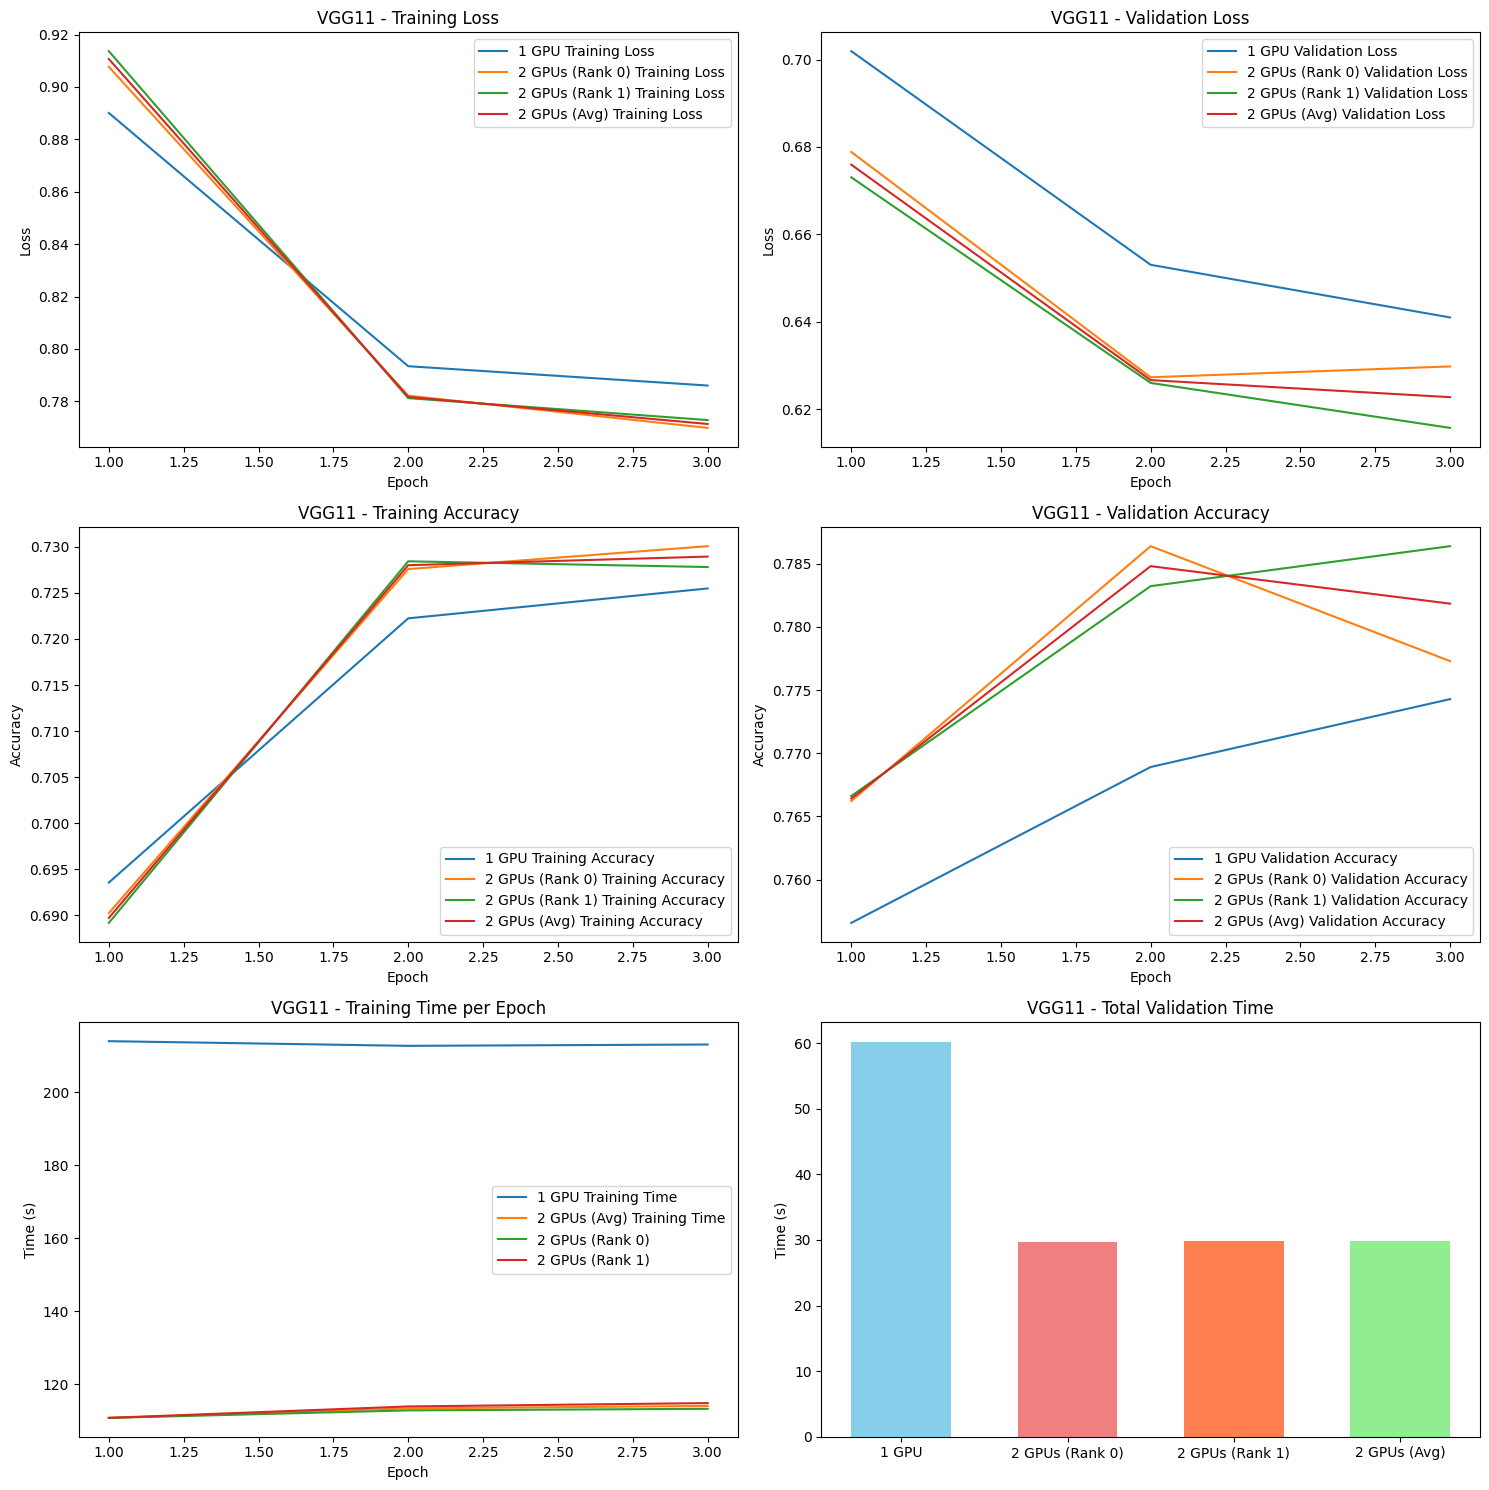

Test accuracy with 1 GPU: 0.7676
Test accuracy with 2 GPUs (average): 0.7749


In [46]:
model = "VGG11"
path_to_save_plots = f"{results_folder}/{model}/"
model_args = args[models_name.index(model)]
print(model_args)
plot_training_metrics(model_args["json_file_1gpu"], model_args["json_file_2gpus"], path_to_save_plots, model)

{'json_file_1gpu': '/content/drive/MyDrive/Distributed system project/plot results//ConvAutoencoder/ConvAutoencoder_10epochs_1GPU.json', 'json_file_2gpus': '/content/drive/MyDrive/Distributed system project/plot results//ConvAutoencoder/ConvAutoencoder_10epochs_2GPU.json', 'json_file_2gpu_ddp': None}


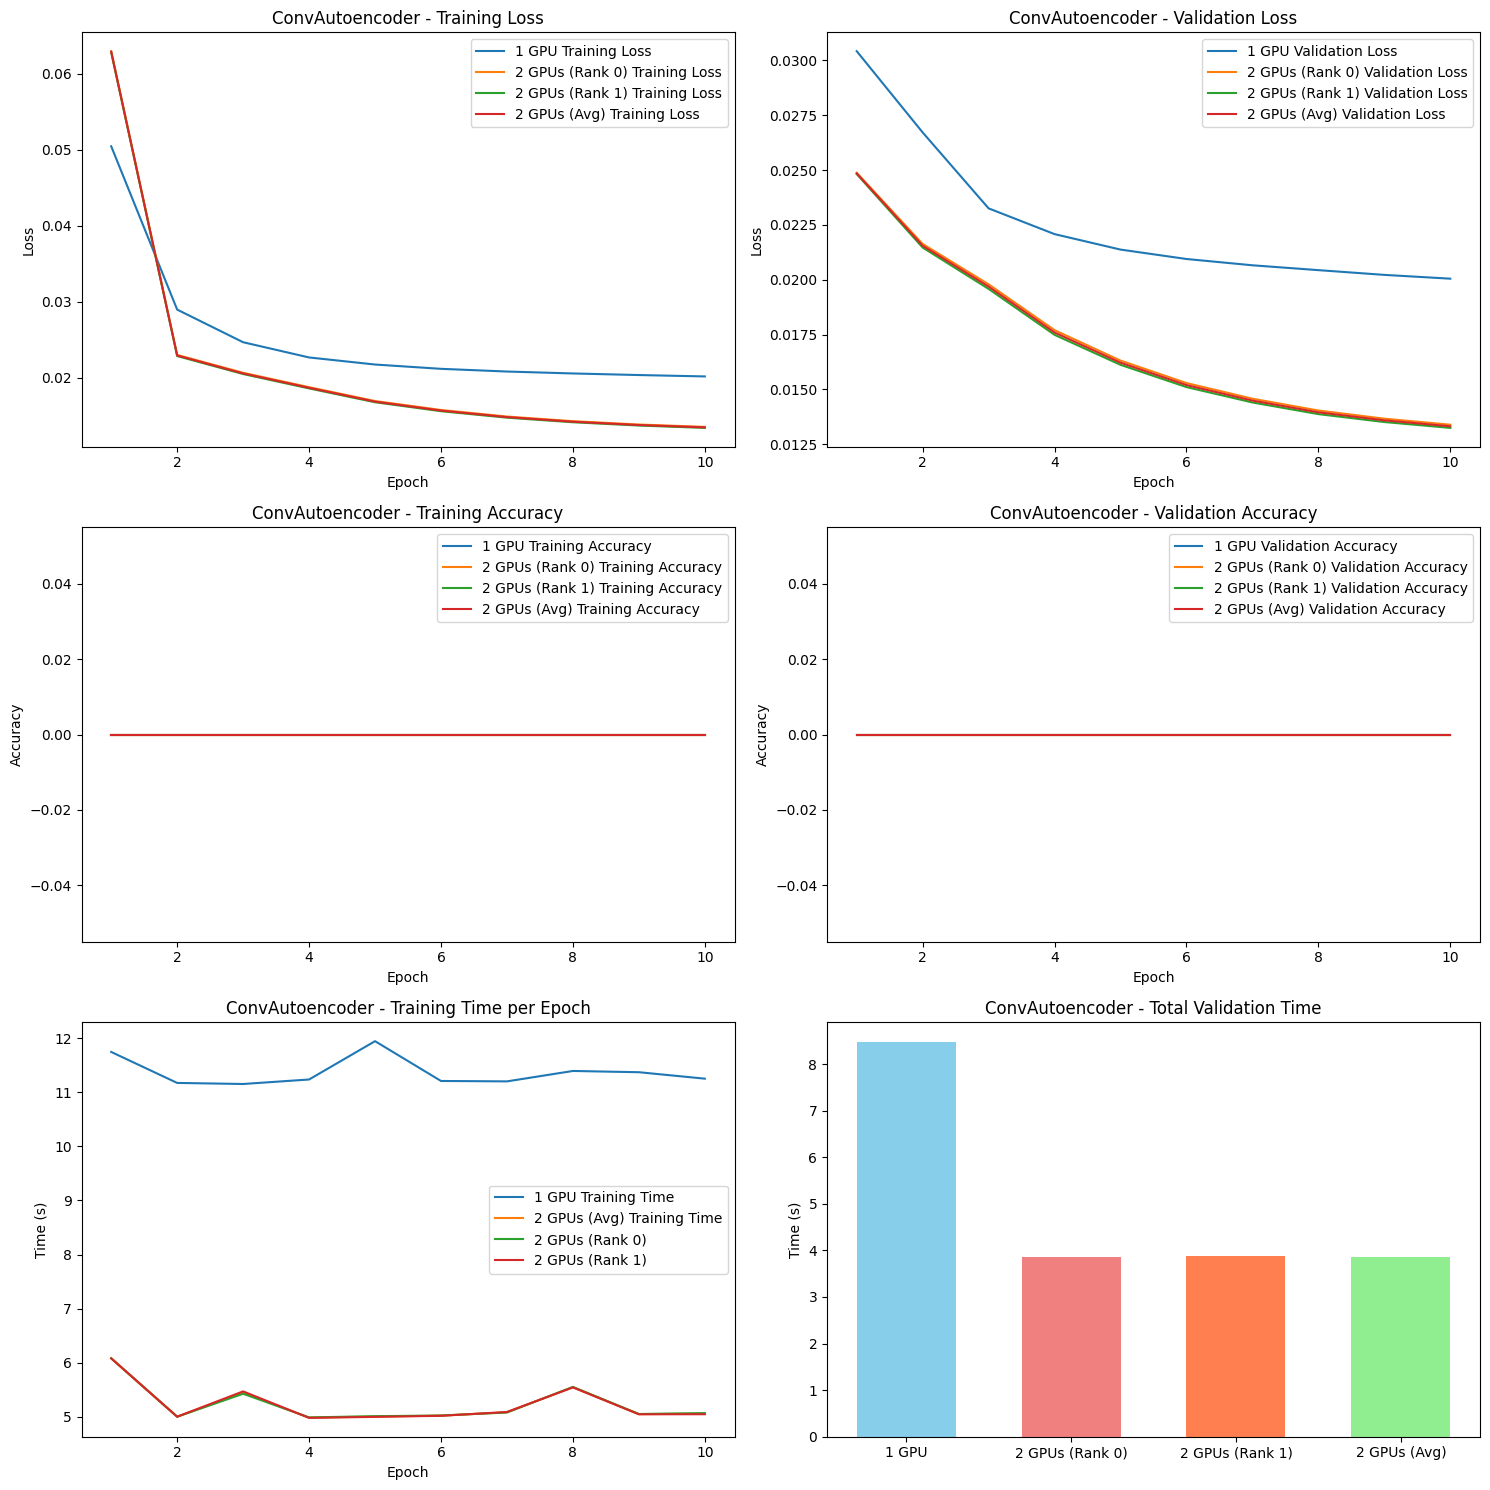

Test accuracy with 1 GPU: 0.0000
Test accuracy with 2 GPUs (average): 0.0000


In [47]:
model = "ConvAutoencoder"
path_to_save_plots = f"{results_folder}/{model}/"
model_args = args[models_name.index(model)]
print(model_args)
plot_training_metrics(model_args["json_file_1gpu"], model_args["json_file_2gpus"], path_to_save_plots, model)

{'json_file_1gpu': '/content/drive/MyDrive/Distributed system project/plot results//Seq2Seq/seq2seq_10epochs_1GPU.json', 'json_file_2gpus': '/content/drive/MyDrive/Distributed system project/plot results//Seq2Seq/seq2seq_10epochs_2GPU.json', 'json_file_2gpu_ddp': None}


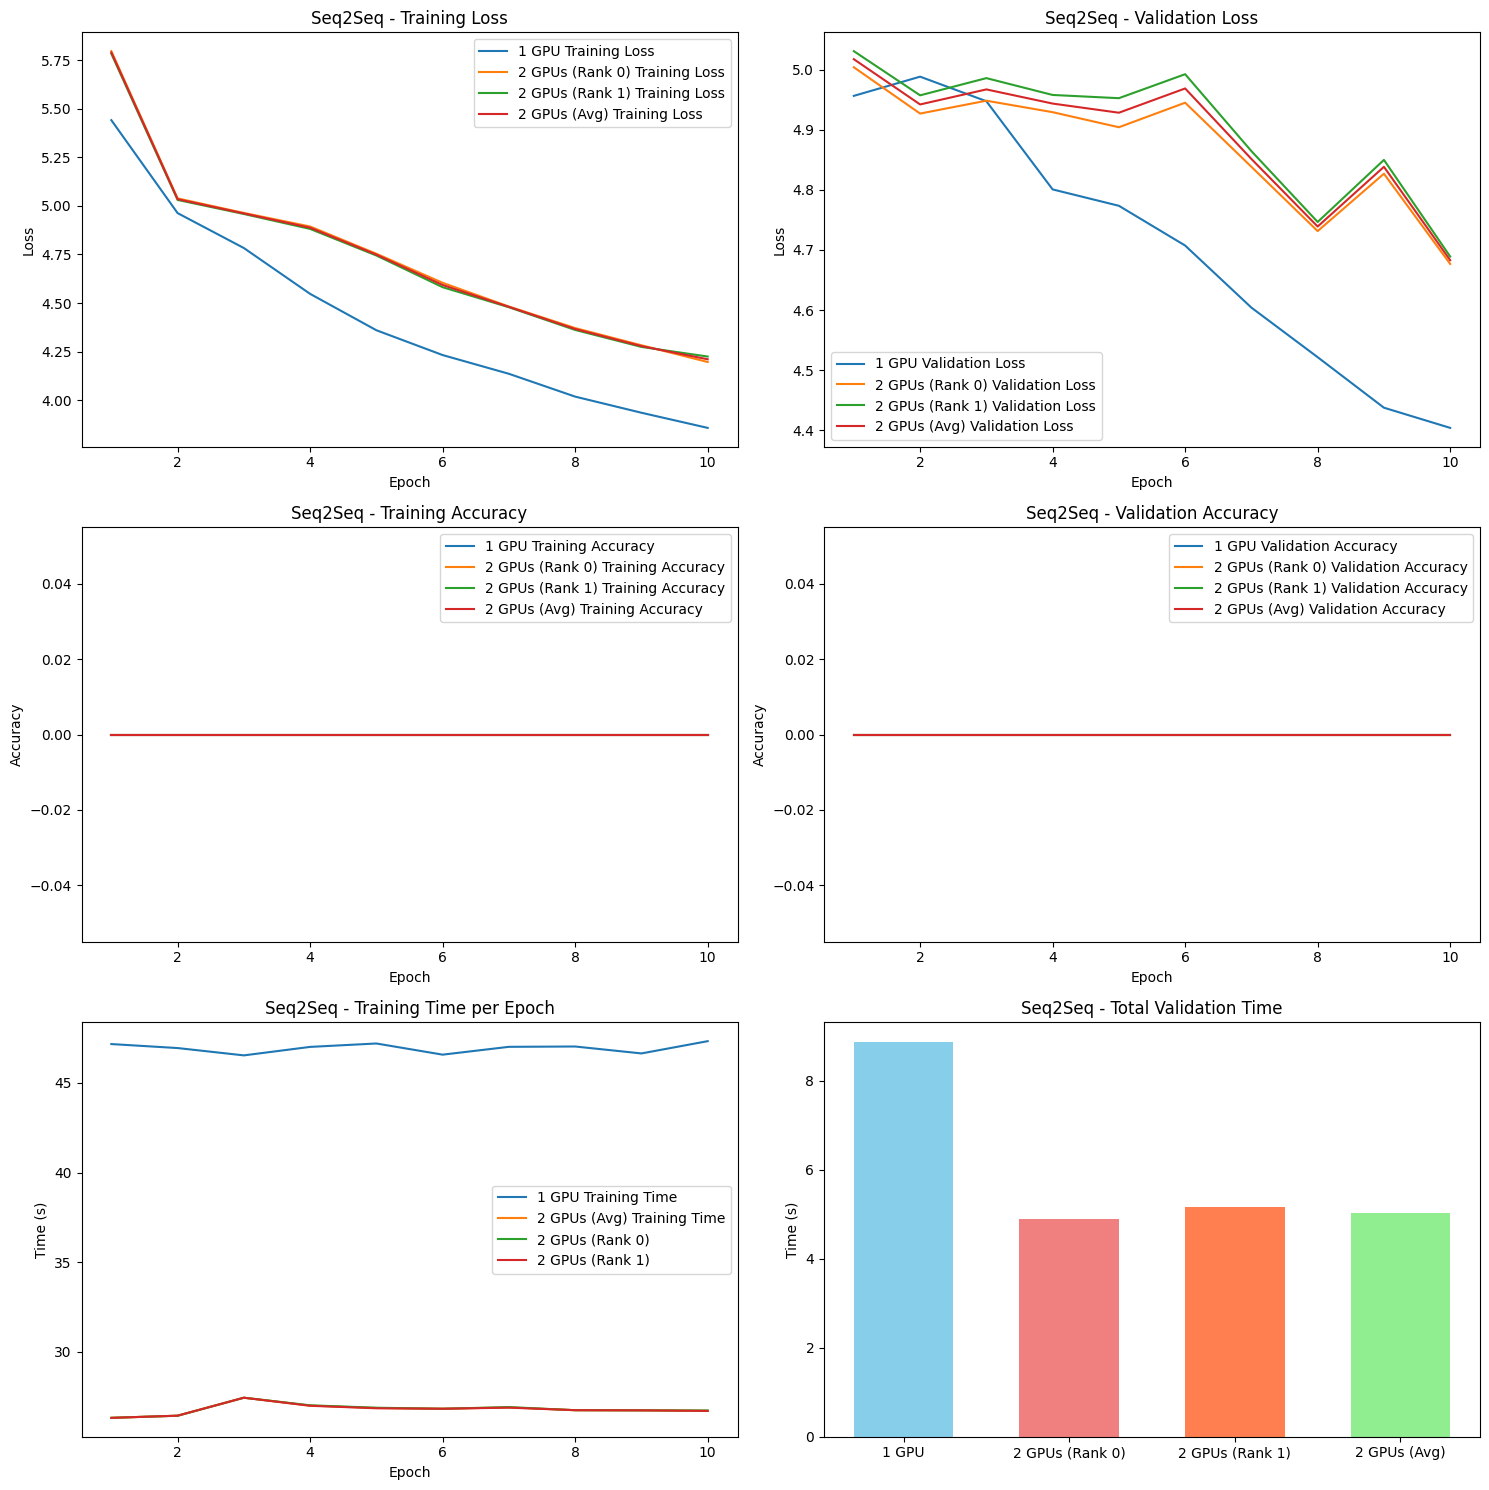

Test accuracy with 1 GPU: 0.0000
Test accuracy with 2 GPUs (average): 0.0000


In [48]:
model = "Seq2Seq"
path_to_save_plots = f"{results_folder}/{model}/"
model_args = args[models_name.index(model)]
print(model_args)
plot_training_metrics(model_args["json_file_1gpu"], model_args["json_file_2gpus"], path_to_save_plots, model)

{'json_file_1gpu': '/content/drive/MyDrive/Distributed system project/plot results//CNN/CNN_20epochs_1GPU.json', 'json_file_2gpus': '/content/drive/MyDrive/Distributed system project/plot results//CNN/CNN_20epochs_2GPU.json', 'json_file_2gpu_ddp': None}


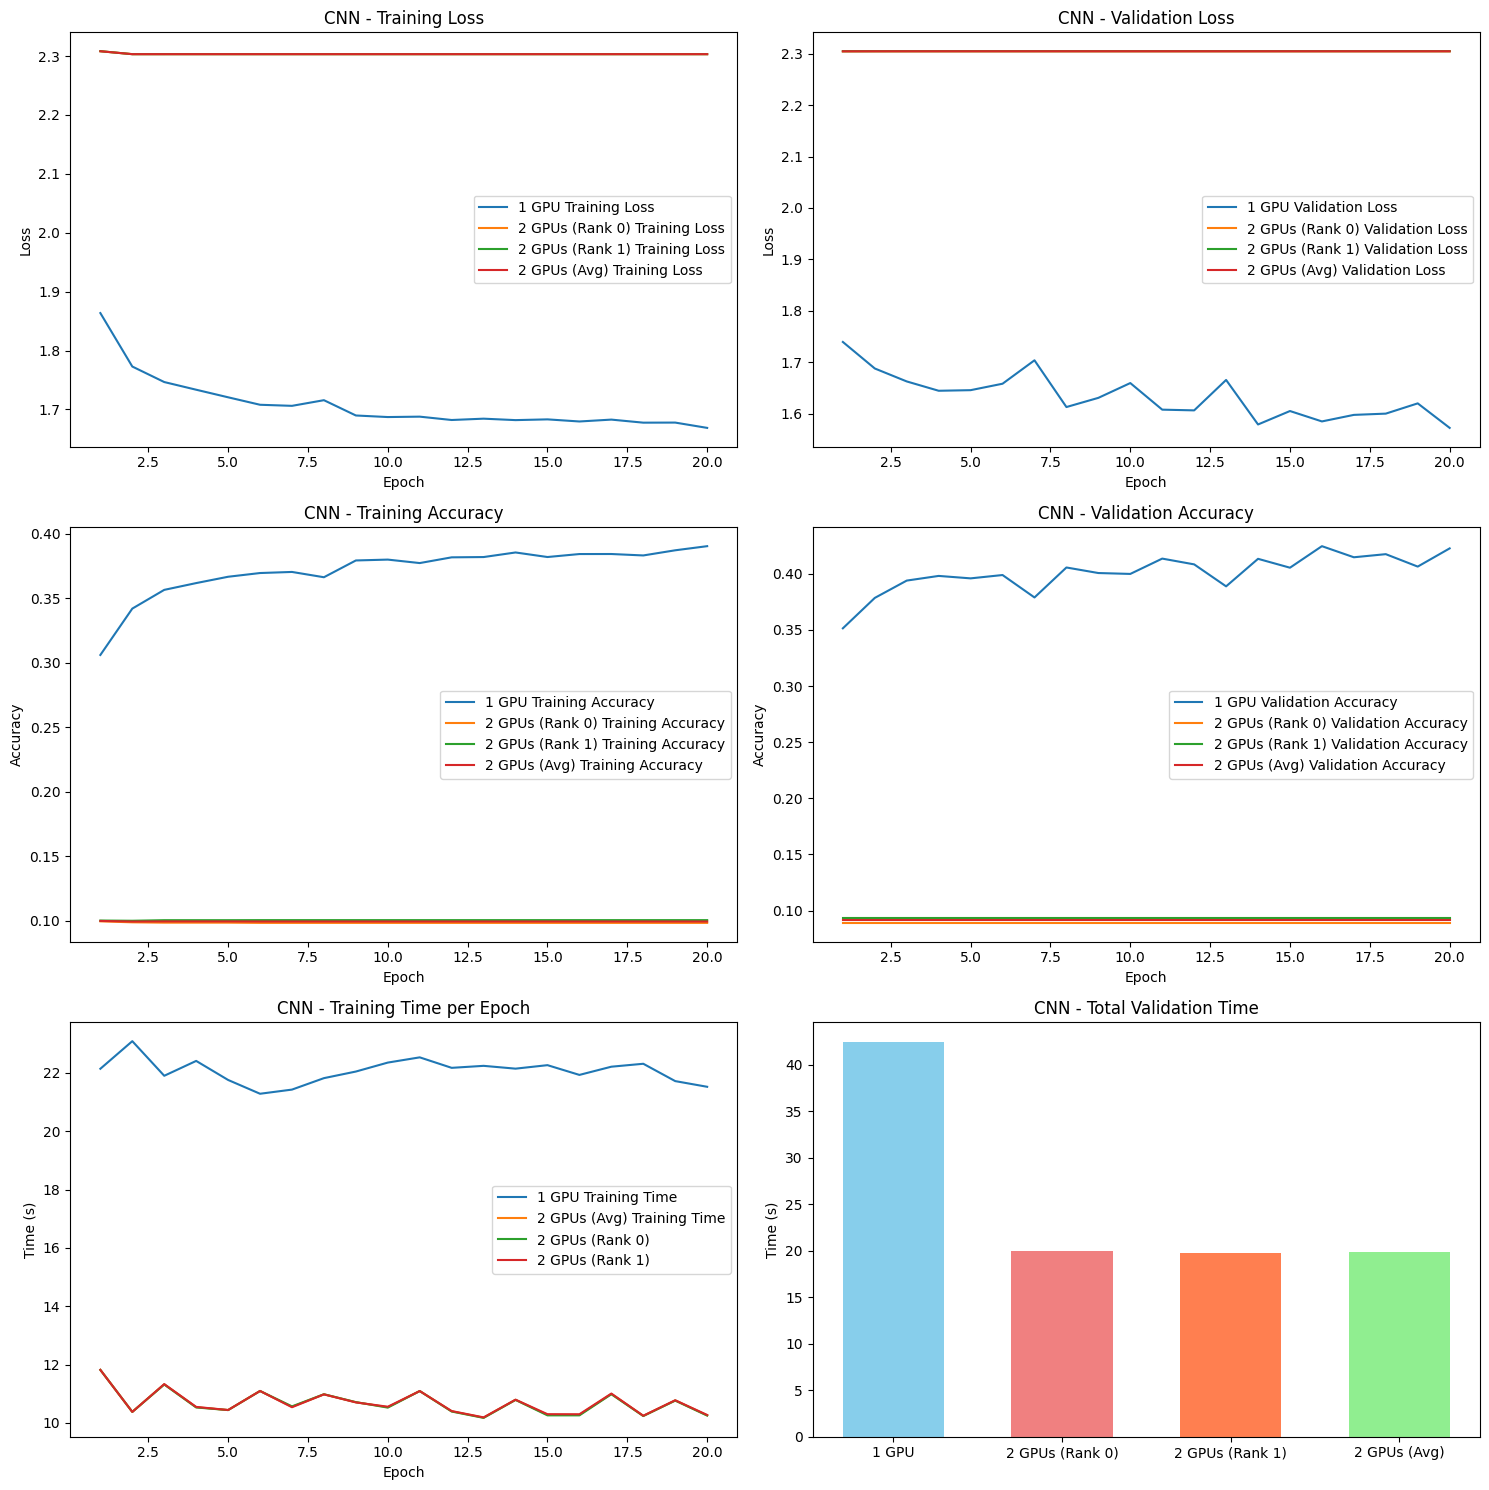

Test accuracy with 1 GPU: 0.4359
Test accuracy with 2 GPUs (average): 0.1004


In [49]:
model = "CNN"
path_to_save_plots = f"{results_folder}/{model}/"
model_args = args[models_name.index(model)]
print(model_args)
plot_training_metrics(model_args["json_file_1gpu"], model_args["json_file_2gpus"], path_to_save_plots, model)

{'json_file_1gpu': '/content/drive/MyDrive/Distributed system project/plot results//NBoW/NBoW_5epochs_1GPU.json', 'json_file_2gpus': '/content/drive/MyDrive/Distributed system project/plot results//NBoW/NBoW_5epochs_2GPU.json', 'json_file_2gpu_ddp': None}


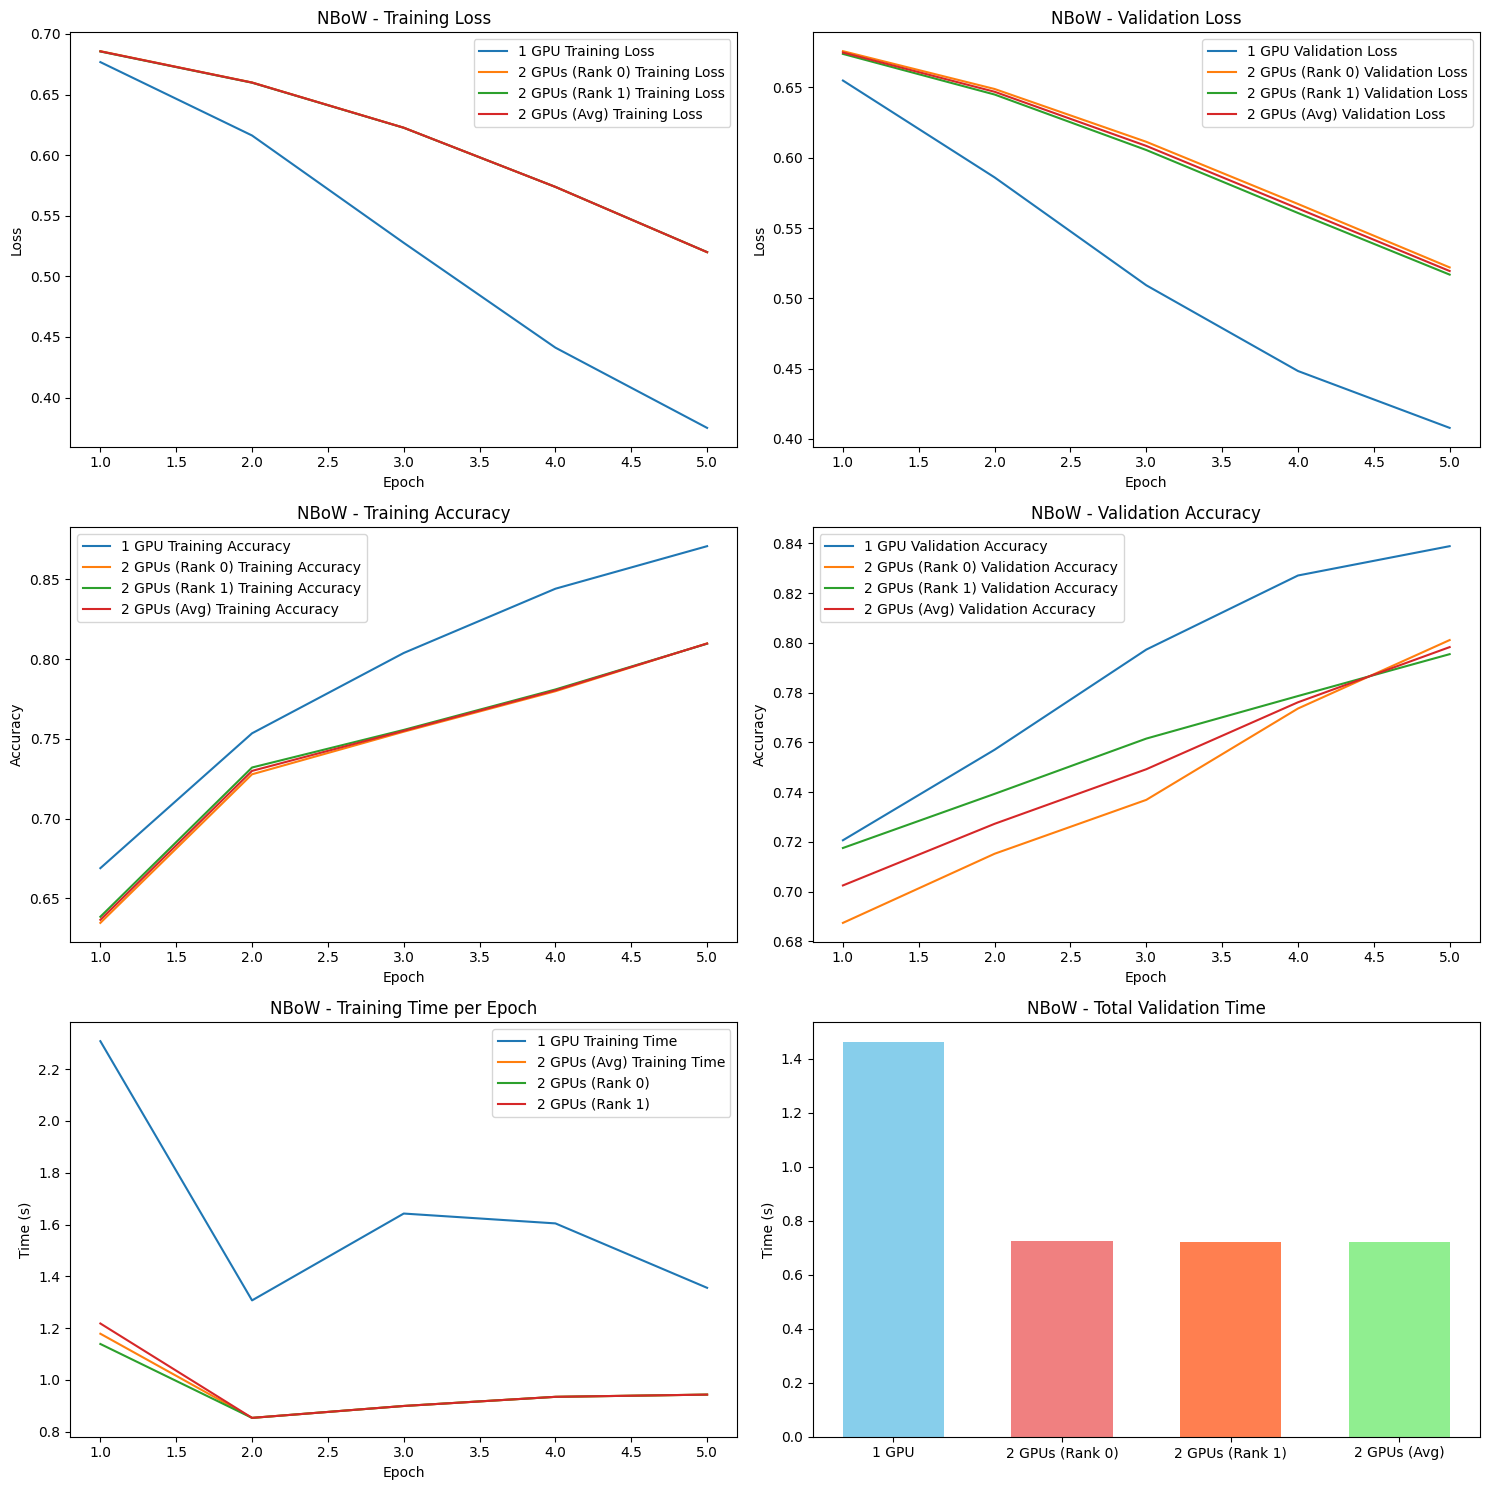

Test accuracy with 1 GPU: 0.8396
Test accuracy with 2 GPUs (average): 0.7926


In [82]:
model = "NBoW"
path_to_save_plots = f"{results_folder}/{model}/"
model_args = args[models_name.index(model)]
print(model_args)
plot_training_metrics(model_args["json_file_1gpu"], model_args["json_file_2gpus"], path_to_save_plots, model)

In [84]:
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os

def plot_training_metrics(json_file_1gpu, json_file_2gpus_mp, json_file_2gpus, path_to_save_plots, model_name):
    """
    Generates plots comparing training metrics from 1-GPU and 2-GPU setups.

    Args:
        json_file_1gpu (str): Path to the JSON file containing 1-GPU training data.
        json_file_2gpus (str): Path to the JSON file containing 2-GPU training data.
        path_to_save_plots (str): Path to save the generated plots.
        model_name (str): Name of the model, to be included in plot titles.
    """

    def extract_data(json_file):
        """Extracts data from JSON file and returns the values."""
        with open(json_file, 'r') as f:
            data = json.load(f)

        # Assuming one entry in json object for 1 gpu case and two entry for 2 gpu case.
        if len(data) == 1:
            key = list(data.keys())[0]
            return data[key]
        elif len(data) == 2:
             keys = list(data.keys())
             return data[keys[0]], data[keys[1]]

        else:
            keys = list(data.keys())
            return data[keys[1]], data[keys[2]]

    # Load JSON data
    data_1gpu = extract_data(json_file_1gpu)
    data_2gpu_mp = extract_data(json_file_2gpus_mp)
    data_2gpus_rank0, data_2gpus_rank1 = extract_data(json_file_2gpus)


    # Extract data for 1 GPU
    train_times_1gpu = data_1gpu.get('training_times', [])
    train_losses_1gpu = data_1gpu.get('train_losses', [])
    train_acc_1gpu = data_1gpu.get('train_accurcy', [])
    val_times_1gpu = data_1gpu.get('validation_times', [])
    val_losses_1gpu = data_1gpu.get('validation_losses', [])
    val_acc_1gpu = data_1gpu.get('validation_accurcy', [])
    test_acc_1gpu = data_1gpu.get('test_acc', 0)

    # Extract data for 2 GPU with model pralilsme
    train_times_2gpu_mp = data_2gpu_mp.get('training_times', [])
    train_losses_2gpu_mp = data_2gpu_mp.get('train_losses', [])
    train_acc_2gpu_mp = data_2gpu_mp.get('train_accurcy', [])
    val_times_2gpu_mp = data_2gpu_mp.get('validation_times', [])
    val_losses_2gpu_mp = data_2gpu_mp.get('validation_losses', [])
    val_acc_2gpu_mp = data_2gpu_mp.get('validation_accurcy', [])
    test_acc_2gpu_mp = data_2gpu_mp.get('test_acc', 0)


    # Extract data for 2 GPUs (rank 0)
    train_times_2gpus_rank0 = data_2gpus_rank0.get('training_times', [])
    train_losses_2gpus_rank0 = data_2gpus_rank0.get('train_losses', [])
    train_acc_2gpus_rank0 = data_2gpus_rank0.get('train_accurcy', [])
    val_times_2gpus_rank0 = data_2gpus_rank0.get('validation_times', [])
    val_losses_2gpus_rank0 = data_2gpus_rank0.get('validation_losses', [])
    val_acc_2gpus_rank0 = data_2gpus_rank0.get('validation_accurcy', [])
    test_acc_2gpus_rank0 = data_2gpus_rank0.get('test_acc', 0)


    # Extract data for 2 GPUs (rank 1)
    train_times_2gpus_rank1 = data_2gpus_rank1.get('training_times', [])
    train_losses_2gpus_rank1 = data_2gpus_rank1.get('train_losses', [])
    train_acc_2gpus_rank1 = data_2gpus_rank1.get('train_accurcy', [])
    val_times_2gpus_rank1 = data_2gpus_rank1.get('validation_times', [])
    val_losses_2gpus_rank1 = data_2gpus_rank1.get('validation_losses', [])
    val_acc_2gpus_rank1 = data_2gpus_rank1.get('validation_accurcy', [])
    test_acc_2gpus_rank1 = data_2gpus_rank1.get('test_acc', 0)

    # Calculate averages for 2 GPUs
    train_times_2gpus_avg = np.mean([train_times_2gpus_rank0, train_times_2gpus_rank1], axis=0) if (train_times_2gpus_rank0 and train_times_2gpus_rank1) else []
    train_losses_2gpus_avg = np.mean([train_losses_2gpus_rank0, train_losses_2gpus_rank1], axis=0) if (train_losses_2gpus_rank0 and train_losses_2gpus_rank1) else []
    train_acc_2gpus_avg = np.mean([train_acc_2gpus_rank0, train_acc_2gpus_rank1], axis=0) if (train_acc_2gpus_rank0 and train_acc_2gpus_rank1) else []
    val_times_2gpus_avg = np.mean([val_times_2gpus_rank0, val_times_2gpus_rank1], axis=0) if (val_times_2gpus_rank0 and val_times_2gpus_rank1) else []
    val_losses_2gpus_avg = np.mean([val_losses_2gpus_rank0, val_losses_2gpus_rank1], axis=0) if (val_losses_2gpus_rank0 and val_losses_2gpus_rank1) else []
    val_acc_2gpus_avg = np.mean([val_acc_2gpus_rank0, val_acc_2gpus_rank1], axis=0) if (val_acc_2gpus_rank0 and val_acc_2gpus_rank1) else []
    test_acc_2gpus_avg = np.mean([test_acc_2gpus_rank0, test_acc_2gpus_rank1]) if (test_acc_2gpus_rank0 and test_acc_2gpus_rank1) else 0

    epochs = range(1, len(train_losses_1gpu) + 1) if train_losses_1gpu else []

    # --- Plotting ----
    plt.figure(figsize=(15, 15))

    # Plot Training Loss
    plt.subplot(3, 2, 1)
    if train_losses_1gpu:
         plt.plot(epochs, train_losses_1gpu, label='1 GPU Training Loss')
    if train_times_2gpu_mp:
        plt.plot(epochs, train_losses_2gpu_mp, label='2 GPUs (MP-DDP) Training Loss')
    if len(train_losses_2gpus_rank0) > 0:
        plt.plot(epochs, train_losses_2gpus_rank0, label='2 GPUs (Rank 0) Training Loss')
    if len(train_losses_2gpus_rank1) > 0:
        plt.plot(epochs, train_losses_2gpus_rank1, label='2 GPUs (Rank 1) Training Loss')
    if len(train_losses_2gpus_avg) > 0:
        plt.plot(epochs, train_losses_2gpus_avg, label='2 GPUs (Avg) Training Loss')

    plt.title(f'{model_name} - Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Plot Validation Loss
    plt.subplot(3, 2, 2)
    if val_losses_1gpu:
        plt.plot(epochs, val_losses_1gpu, label='1 GPU Validation Loss')
    if val_times_2gpu_mp:
        plt.plot(epochs, val_losses_2gpu_mp, label='2 GPUs (MP-DDP) Validation Loss')
    if len(val_losses_2gpus_rank0) > 0:
        plt.plot(epochs, val_losses_2gpus_rank0, label='2 GPUs (Rank 0) Validation Loss')
    if len(val_losses_2gpus_rank1) > 0:
         plt.plot(epochs, val_losses_2gpus_rank1, label='2 GPUs (Rank 1) Validation Loss')
    if len(val_losses_2gpus_avg) > 0:
        plt.plot(epochs, val_losses_2gpus_avg, label='2 GPUs (Avg) Validation Loss')
    plt.title(f'{model_name} - Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Plot Training Accuracy
    plt.subplot(3, 2, 3)
    if train_acc_1gpu:
        plt.plot(epochs, train_acc_1gpu, label='1 GPU Training Accuracy')
    if train_acc_2gpu_mp:
        plt.plot(epochs, train_acc_2gpu_mp, label='2 GPUs (MP-DDP) Training Accuracy')
    if len(train_acc_2gpus_rank0) > 0:
        plt.plot(epochs, train_acc_2gpus_rank0, label='2 GPUs (Rank 0) Training Accuracy')
    if len(train_acc_2gpus_rank1) > 0:
        plt.plot(epochs, train_acc_2gpus_rank1, label='2 GPUs (Rank 1) Training Accuracy')
    if len(train_acc_2gpus_avg) > 0:
        plt.plot(epochs, train_acc_2gpus_avg, label='2 GPUs (Avg) Training Accuracy')
    plt.title(f'{model_name} - Training Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot Validation Accuracy
    plt.subplot(3, 2, 4)
    if val_acc_1gpu:
        plt.plot(epochs, val_acc_1gpu, label='1 GPU Validation Accuracy')
    if val_acc_2gpu_mp:
        plt.plot(epochs, val_acc_2gpu_mp, label='2 GPUs (MP-DDP) Validation Accuracy')
    if len(val_acc_2gpus_rank0) > 0:
         plt.plot(epochs, val_acc_2gpus_rank0, label='2 GPUs (Rank 0) Validation Accuracy')
    if len(val_acc_2gpus_rank1) > 0:
         plt.plot(epochs, val_acc_2gpus_rank1, label='2 GPUs (Rank 1) Validation Accuracy')
    if len(val_acc_2gpus_avg) > 0:
         plt.plot(epochs, val_acc_2gpus_avg, label='2 GPUs (Avg) Validation Accuracy')
    plt.title(f'{model_name} - Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot Training Times
    plt.subplot(3, 2, 5)
    if train_times_1gpu:
        plt.plot(epochs, train_times_1gpu, label='1 GPU Training Time')

    if train_times_2gpu_mp:
        plt.plot(epochs, train_times_2gpu_mp, label='2 GPUs (MP-DDP) Training Time')
    if len(train_times_2gpus_avg) > 0:
        plt.plot(epochs, train_times_2gpus_avg, label='2 GPUs (Avg) Training Time')
    if len(train_times_2gpus_rank0) > 0:
        plt.plot(epochs, train_times_2gpus_rank0, label='2 GPUs (Rank 0)')
    if len(train_times_2gpus_rank1) > 0:
        plt.plot(epochs, train_times_2gpus_rank1, label='2 GPUs (Rank 1)')
    plt.title(f'{model_name} - Training Time per Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Time (s)')
    plt.legend()

    # --- Bar chart for total validation time ---
    val_time_1gpu_total = np.sum(val_times_1gpu) if val_times_1gpu else 0
    val_time_2gpu_mp_total = np.sum(val_times_2gpu_mp) if val_times_2gpu_mp else 0
    val_time_2gpus_total_rank0 = np.sum(val_times_2gpus_rank0) if val_times_2gpus_rank0 else 0
    val_time_2gpus_total_rank1 = np.sum(val_times_2gpus_rank1) if val_times_2gpus_rank1 else 0
    val_time_2gpus_total_avg = np.sum(val_times_2gpus_avg) if len(val_times_2gpus_avg) > 0 else 0

    labels = ['1 GPU', '2 GPUs MP-DDP', '2 GPUs (Rank 0)', '2 GPUs (Rank 1)', '2 GPUs (Avg)']
    total_val_times = [val_time_1gpu_total, val_time_2gpu_mp_total, val_time_2gpus_total_rank0,val_time_2gpus_total_rank1, val_time_2gpus_total_avg]

    plt.subplot(3,2,6)
    bar_width = 0.6
    index = np.arange(len(labels))
    plt.bar(index, total_val_times, color=['skyblue', 'lightcoral', 'coral', 'lightgreen'], width = bar_width)
    plt.xticks(index, labels)
    plt.title(f'{model_name} - Total Validation Time')
    plt.ylabel('Time (s)')
    plt.tight_layout()


    # Create the directory if it doesn't exist
    os.makedirs(path_to_save_plots, exist_ok=True)

    # Save the combined plot
    plt.savefig(os.path.join(path_to_save_plots, f'{model_name}_training_metrics.png'))
    plt.show()
    plt.close()

    print(f"Test accuracy with 1 GPU: {test_acc_1gpu:.4f}")
    print(f"Test accuracy with 2 GPUs (average): {test_acc_2gpus_avg:.4f}")

{'json_file_1gpu': '/content/drive/MyDrive/Distributed system project/plot results//MLP/MLP_10epochs_1GPU.json', 'json_file_2gpus': '/content/drive/MyDrive/Distributed system project/plot results//MLP/MLP_10epochs_2GPU.json', 'json_file_2gpu_ddp': '/content/drive/MyDrive/Distributed system project/plot results//MLP/MLP_10epochs_2GPU_DDP.json'}


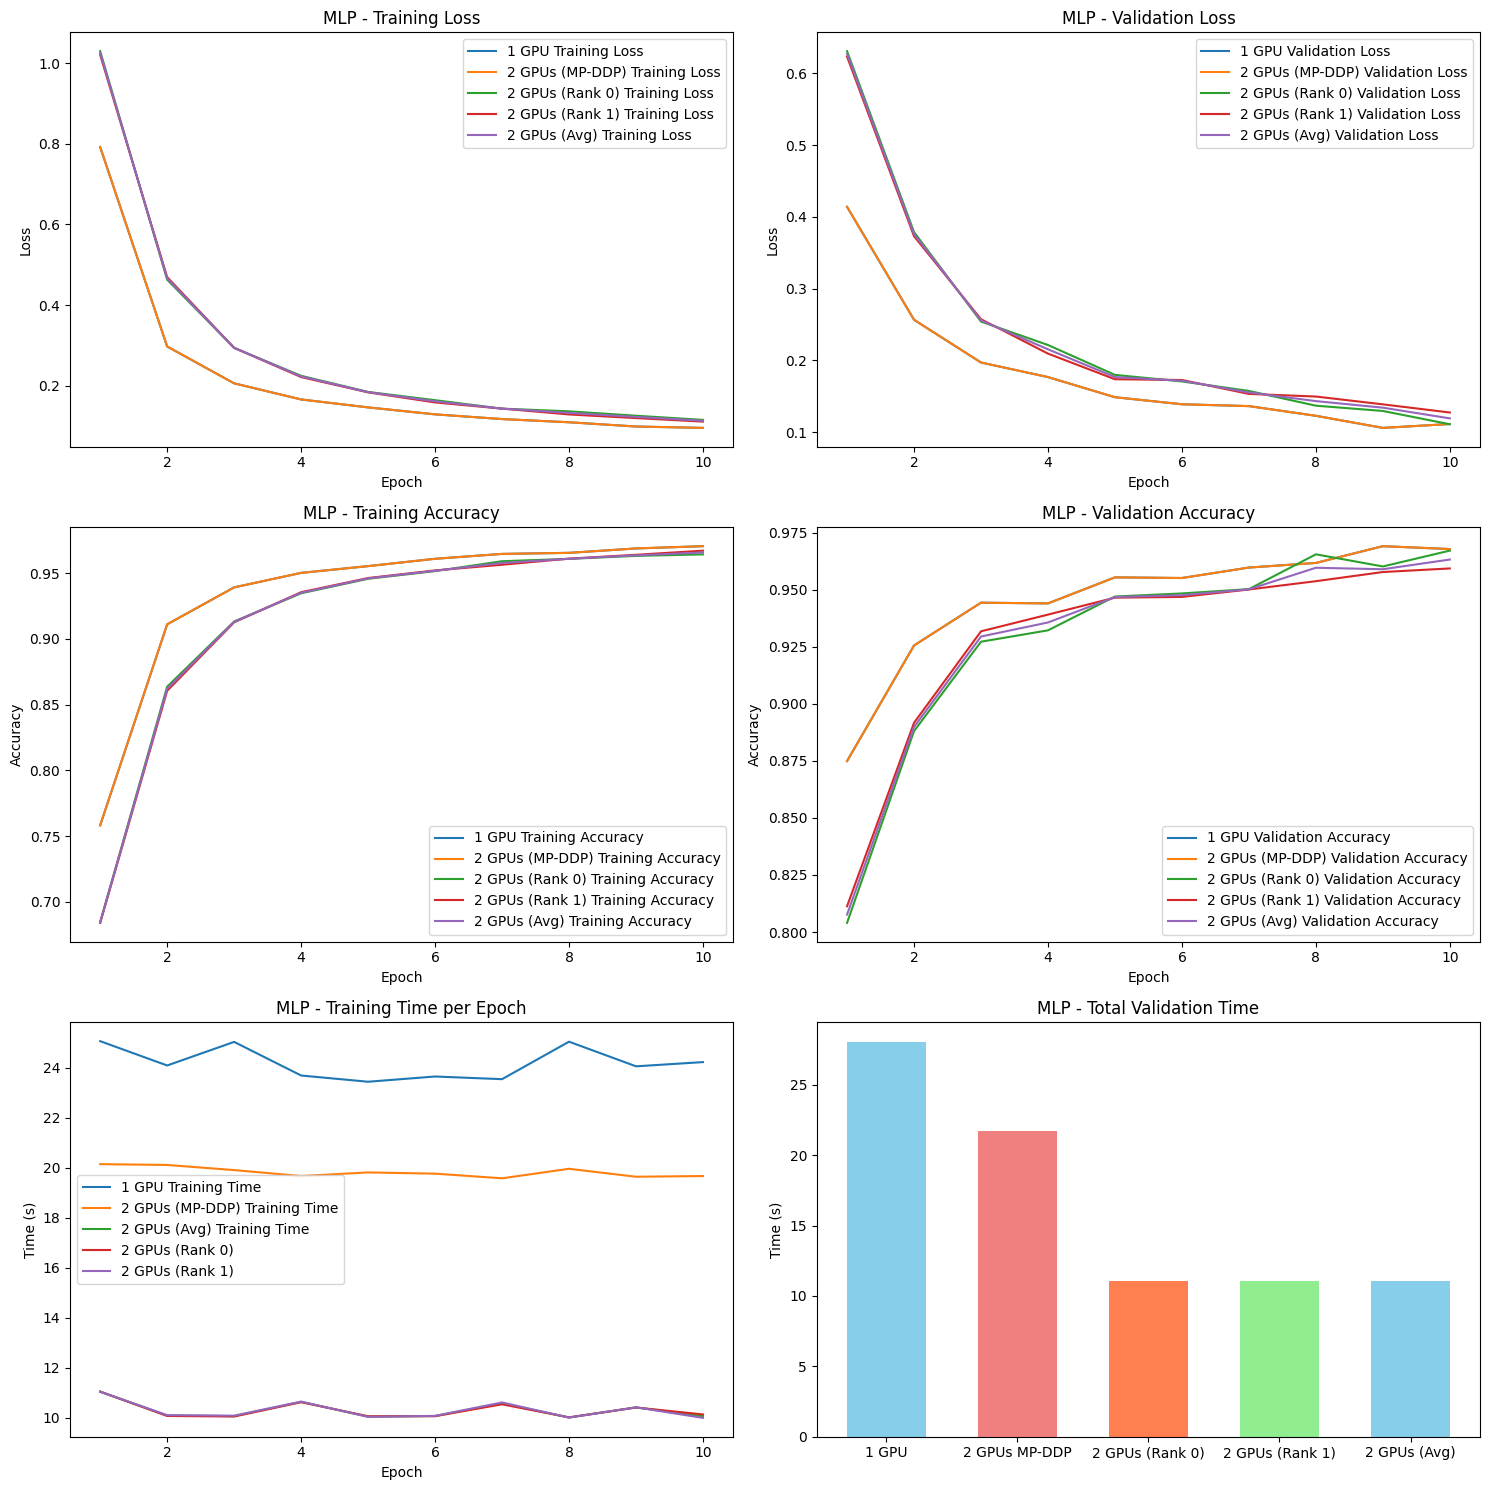

Test accuracy with 1 GPU: 0.9806
Test accuracy with 2 GPUs (average): 0.9761


In [85]:
model = "MLP"
path_to_save_plots = f"{results_folder}/{model}/"
model_args = args[models_name.index(model)]
print(model_args)
plot_training_metrics(model_args["json_file_1gpu"],model_args["json_file_2gpus"], model_args["json_file_2gpu_ddp"], path_to_save_plots, model)